Implimenting Linear regression on dataset of Titanic Passengers

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv("database/titanic_train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We won't be needing Name, Ticket and Embarked Data for prediction

In [2]:
train = train.drop(["Ticket", "Embarked", "Name"], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,male,22.0,1,0,7.2500,NaN
1,2,1,1,female,38.0,1,0,71.2833,C85
2,3,1,3,female,26.0,0,0,7.9250,NaN
3,4,1,1,female,35.0,1,0,53.1000,C123
4,5,0,3,male,35.0,0,0,8.0500,NaN


Sex needs to be changed to 1, 0 and we must see if what Cabin is about. It seems to have too many NaN values. Does Parch have all 0s?

In [3]:
train["Cabin"].isna().sum()
# too many null values. Dropping the column
train = train.drop(["Cabin"], axis= 1)

In [4]:
from sklearn.preprocessing import OrdinalEncoder

#Ordinal encoding
ordinalencoder = OrdinalEncoder()
train[["Sex"]] = ordinalencoder.fit_transform(train[["Sex"]])

train["Sex"].head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: Sex, dtype: float64

In [5]:
train.head()
train["Parch"].head(20)
#No, parch does not have all 0s.
np.sum(train.isnull())
#some of the values in Age are not known
train = train.dropna(how = "any")
np.sum(train.isnull())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

Let's split the data into x and y.

In [6]:
X_train = train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
Y_train = train[["Survived"]]

print(X_train.head())
print(X_train.shape)
print(Y_train.head())
print(Y_train.shape)

   Pclass  Sex   Age  SibSp  Parch     Fare
0       3  1.0  22.0      1      0   7.2500
1       1  0.0  38.0      1      0  71.2833
2       3  0.0  26.0      0      0   7.9250
3       1  0.0  35.0      1      0  53.1000
4       3  1.0  35.0      0      0   8.0500
(714, 6)
   Survived
0         0
1         1
2         1
3         1
4         0
(714, 1)


Now, we do the same with Test dataset

In [7]:
test = pd.read_csv("database/titanic_test.csv")

test[["Sex"]] = ordinalencoder.transform(test[["Sex"]])
X_test = test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]

Y_test = pd.read_csv("database/titanic_test_survived.csv")[["Survived"]]

print(X_test.head())
print(X_test.shape)
print(Y_test.head())
print(Y_test.shape)

   Pclass  Sex   Age  SibSp  Parch     Fare
0       3  1.0  34.5      0      0   7.8292
1       3  0.0  47.0      1      0   7.0000
2       2  1.0  62.0      0      0   9.6875
3       3  1.0  27.0      0      0   8.6625
4       3  0.0  22.0      1      1  12.2875
(418, 6)
   Survived
0         0
1         1
2         0
3         0
4         1
(418, 1)


We have our test and training sets ready.

In [21]:
def cost_fun(y_pred, Y):
    n_examples = Y.shape[0]
    y_pred[y_pred == 1] = 0.999999
    y_pred[y_pred == 0] = 0.000001

    cost = -(1/n_examples)*np.sum((Y)*np.log(y_pred) + (1-(Y))*np.log(1-y_pred))
    
    return cost

In [9]:
def sigmoid_fun(z):
    sigmoid =  1/(1+np.exp(-z))
    sigmoid[sigmoid.isnull()] = 0

    return sigmoid

In [10]:
def single_step(X, Y, w, b):
    z = w @ X.T + b
    z = z.to_frame()
    z.rename(columns = {0:'Survived'}, inplace = True)
    y_pred = sigmoid_fun(z)
    n_examples = Y.shape[0]

    cost = cost_fun(y_pred, Y)

    dw = (1/n_examples)*(np.dot(X.T, (y_pred - Y)))[0]
    db = (1/n_examples)*(np.sum(y_pred-Y))[0]
    return dw, db, cost

In [11]:
def rand_init(n_features):
    w = np.random.rand(n_features)
    b = np.random.rand()

    return w,b

In [39]:
def fit(X, Y, learning_rate, iterations):
    w,b = rand_init(X.shape[1])

    cost_list = []

    for i in range(0, iterations):
        dw, db, cost = single_step(X, Y, w, b)

        w = w - learning_rate*(dw.T)
        b = b - learning_rate*(db)
        
        if (i%100 == 0):
            cost_list.append(cost)
    
    return w, b, cost_list

In [13]:
def predict(w, b, X):
    z = w @ X.T + b
    z = z.to_frame()
    z.rename(columns = {0:'Survived'}, inplace = True)
    y_pred = sigmoid_fun(z)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    return y_pred

[ 0.4734926   0.15925742 -0.34066329 -0.10228468  0.18763735  0.37802265] -0.1107337691011421


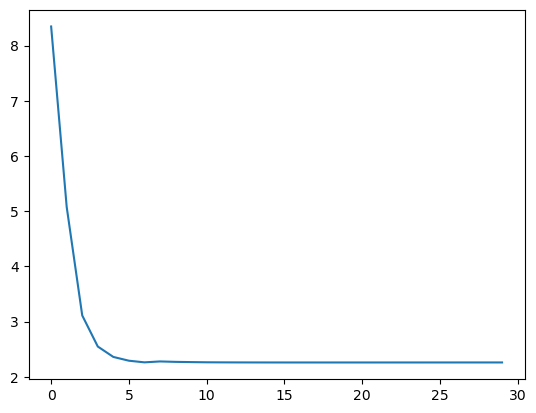

In [40]:
w, b, cost_list = fit(X_train, Y_train, learning_rate=0.001, iterations=3000)
print(w, b)

from matplotlib import pyplot as plt
plt.plot(cost_list)
plt.show()

In [41]:
Y_pred_test = predict(w, b, X_test)
Y_pred_train = predict(w, b, X_train)

from sklearn.metrics import accuracy_score

print("Training Accuracy for training dataset: ", accuracy_score(Y_pred_train, Y_train))
print("Training Accuracy for test dataset: ", accuracy_score(Y_pred_test, Y_test))


Training Accuracy for training dataset:  0.6820728291316527
Training Accuracy for test dataset:  0.6363636363636364
